In [1]:
import typing
from scipy.sparse import spmatrix, csr_matrix
import torch
import torchvision
from scipy.spatial.distance import squareform
import scipy
from numba import jit
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from paradime.relations import NeighborBasedPDist
from paradime.transforms import PerplexityBased, Symmetrize, Normalize
from paradime.paradime import Dataset
from paradime.paradime import NegSampledEdgeDataset

In [3]:
mnist = torchvision.datasets.MNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [4]:
testdata = mnist.data.reshape(-1, 28*28) / 255.
testdata = testdata[:100][np.argsort(mnist.targets[:100])]
testlabels = np.sort(mnist.targets[:100])

In [5]:
diss = NeighborBasedPDist(
    verbose=True,
    transform=[
        PerplexityBased(15, verbose=True),
        Symmetrize('tsne'),
        # NormalizeRows(),
        Normalize()
    ]
)

In [6]:
foo = diss.compute_relations(testdata)

2022-07-08 17:05:37.0: Indexing nearest neighbors.
2022-07-08 17:05:44.9: Calculating probabilities.


In [7]:
dataset = Dataset({
    'data': testdata,
    'labels': testlabels,
})

In [8]:
negedge = NegSampledEdgeDataset(
    dataset,
    foo,
    neg_sampling_rate=5
)

In [14]:
def my_collate(
    raw_batch: list[dict[str, torch.Tensor]]
) -> dict[str, torch.Tensor]:

    indices, unique_ids = np.unique(
        torch.concat([ i['indices'] for i in raw_batch ]),
        return_index=True
    )

    collated_batch = {
        'indices': torch.tensor(indices)
    }

    for k in raw_batch[0]:
        if k not in ['row', 'col', 'rel']:
            collated_batch[k] = torch.concat(
                [ i[k] for i in raw_batch]
            )[unique_ids]
        else:
            collated_batch[k] = torch.concat(
                [ i[k] for i in raw_batch ]
            )
    
    return collated_batch


In [26]:
bar = [ negedge[i] for i in [0, 3, 5] ]

In [31]:
my_collate(bar)['rel'].shape

torch.Size([18])

In [14]:
bar = my_collate(
    [ negedge[i] for i in [0, 1,5, 75] ]
)

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

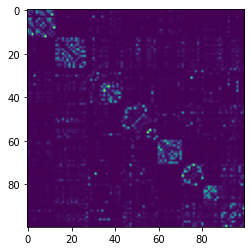

In [24]:
myps = foo.data.toarray()
plt.imshow(myps)

In [8]:
import openTSNE

In [9]:
otp = openTSNE.affinity.PerplexityBasedNN(testdata, 30)

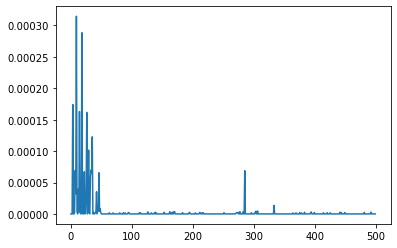

In [23]:
plt.plot(otp.P.toarray()[0])

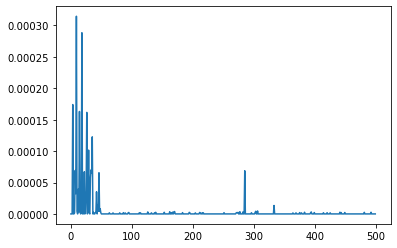

In [24]:
plt.plot(myps[0])

In [4]:
dist = np.array([
    [0., 1., 2.],
    [1., 0., 3.],
    [2., 3., 0.]
])

In [5]:
foo = Precomputed(dist)